In [21]:
import rpy2
import snpytools as snpy
import pandas as pd
import numpy as np
import arrow
def q(sql):
    return snpy.df_from_presto(sql, user_name='jerrychi')
import matplotlib as mpl
from pylab import rcParams
from matplotlib import pyplot as plt
import chartify
from bokeh.models import HoverTool
from bokeh.layouts import gridplot
from bokeh.io import show

In [9]:
# matplotlib default settings
plt.style.use('ggplot')
rcParams['figure.figsize'] = 9,10 
mpl.rcParams.update({'font.size': 18,
                     'axes.titlesize' : 24,
                    'axes.labelsize' : 20,
                    'legend.fontsize': 15,
                    'lines.linewidth' : 3,
                    'lines.markersize' : 10,
                    'xtick.labelsize' : 16,                     
                    'ytick.labelsize' : 16})
formatter = mpl.ticker.StrMethodFormatter('{x:,.0f}')

In [10]:
%load_ext rpy2.ipython

In [11]:
%%capture
%%R 
require(ggplot2)
require(scales)
require(plotly)
require(glue)
require(reshape2)
require(data.table)
require(cowplot)

In [12]:
start_date = '2017-11-01'
end_date = '2018-01-15'
edition = 'ja_JP'

In [13]:
sql = """
select platform, initial_ip_country, dt, MAX(RANDOM(1000)+3000) active_users 
from business_kpi.daily_agg_fq_segment 
WHERE
dt between '{start_date}' and '{end_date}'
AND edition='{edition}'
GROUP BY 1,2,3
""".format(**locals())

In [14]:
df = snpy.df_from_presto(sql,user_name='jerrychi')

SELECT platform,
       initial_ip_country,
       dt,
       MAX(RANDOM(1000)+3000) active_users
FROM business_kpi.daily_agg_fq_segment
WHERE dt BETWEEN '2017-11-01' AND '2018-01-15'
  AND edition='ja_JP'
GROUP BY 1,
         2,
         3
Length of dataframe is 760


In [15]:
df.iloc[0:5]

,platform,initial_ip_country,dt,active_users
0,ios,IN,2018-01-13,3983
1,android,IN,2017-12-21,3885
2,ios,JP,2018-01-10,3799
3,ios,US,2017-11-30,3944
4,ios,IN,2017-11-18,3726


In [46]:
facet_var = 'initial_ip_country'
charts = []
for facet_var_i in df[facet_var].unique():
    ch = chartify.Chart(blank_labels=True,x_axis_type='datetime', y_axis_type='linear')
    ch.plot.line(data_frame=df[df[facet_var]==facet_var_i].sort_values('dt'), 
                 x_column='dt', y_column='active_users',color_column='platform',line_width=2)
    ch.figure.add_tools(HoverTool(
            tooltips=[
                ('date:', '@dt' + '{%F}'),
                ('platform:', '@platform'),
                ('active_users:', '@active_users' + '{0.0 a}')
            ],
            formatters={
                'dt': 'datetime',
            },
            # display a tooltip whenever the cursor is vertically in line with a glyph
            mode='vline'
        ))
    ch.set_title(f'{facet_var_i}: Active users by platform')
    ch.figure.plot_height=300
    ch.figure.plot_width=400
    ch.set_legend_location('outside_top')
    ch.figure.ygrid.visible = True
    ch.figure.ygrid.grid_line_color = 'gray'
    ch.figure.ygrid.grid_line_dash = [1,1]
    ch.figure.ygrid[0].ticker.desired_num_ticks=8
    charts.append(ch)

test = [x.figure for x in charts]  
print(len(test))
show(gridplot(test,ncols=2))



5


In [31]:
%R -i df

In [34]:
%%R
head(df)

  platform initial_ip_country         dt active_users
0      ios                 IN 2018-01-13         3983
1  android                 IN 2017-12-21         3885
2      ios                 JP 2018-01-10         3799
3      ios                 US 2017-11-30         3944
4      ios                 IN 2017-11-18         3726
5      ios                 IN 2017-11-04         3986


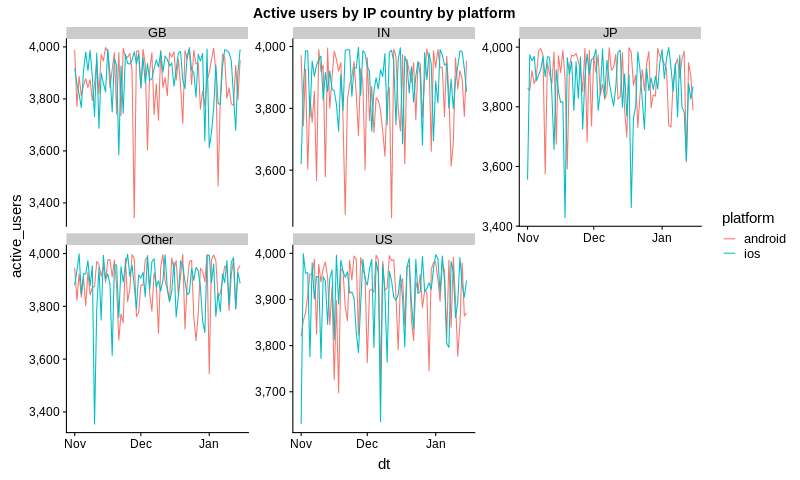

In [37]:
%%R -w 800
df$dt <- as.Date(df$dt)
ggplot(df,aes(dt,active_users,color=platform)) + facet_wrap(~initial_ip_country, scales='free_y')  + 
geom_line() + 
 scale_y_continuous(label=comma)  + theme(text = element_text(size=15)) + 
 ggtitle('Active users by IP country by platform')

In [ ]:
p = df.plot(kind='bar')
p.set_ylabel('rough DAU')
p.set_ylabel('system version')
p.set_title('ja_JP Rough DAU by system version')
p.yaxis.set_major_formatter(formatter)
